In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
train = pd.read_csv('/content/UNSW_NB15_training-set.csv')

In [ ]:
# Print the number of train / test samples
print(f"Train data length: {len(train)}")
print(f"Test data length: {len(test)}")

Train data length: 82332
Test data length: 175341


In [ ]:
test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


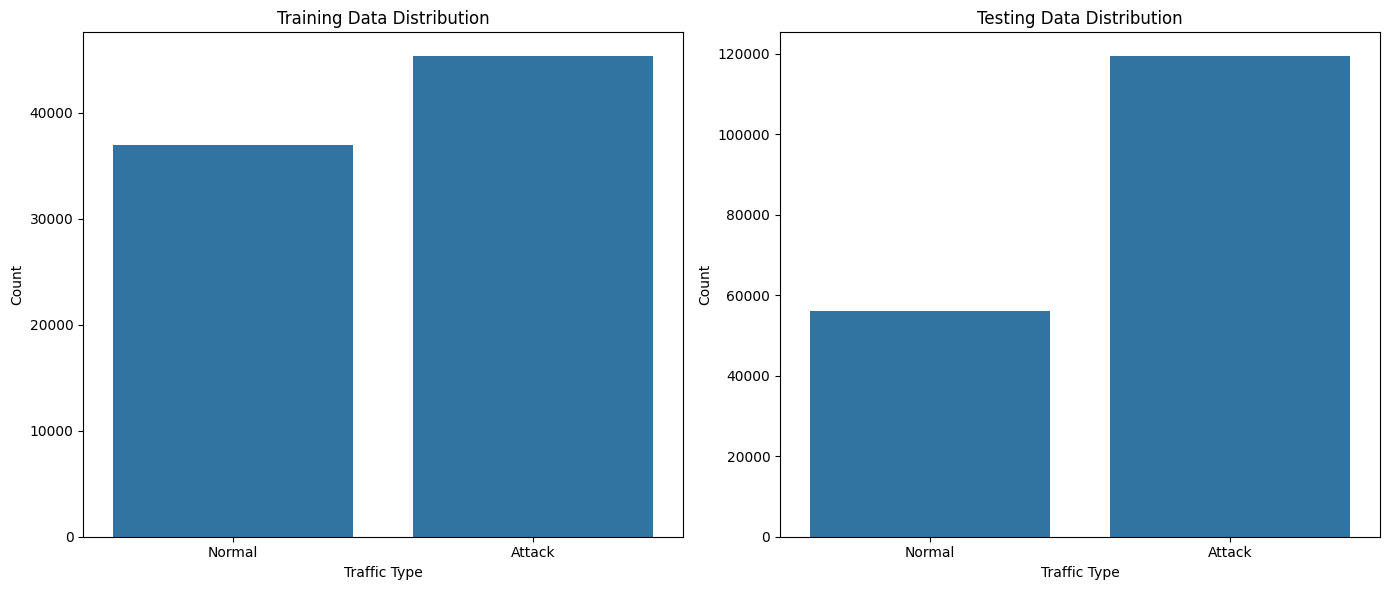

In [ ]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Count plot for training data
sns.countplot(x="label", data=train, ax=axes[0])
axes[0].set_title("Training Data Distribution")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["Normal", "Attack"])
axes[0].set_xlabel("Traffic Type")
axes[0].set_ylabel("Count")

# Count plot for testing data
sns.countplot(x="label", data=test, ax=axes[1])
axes[1].set_title("Testing Data Distribution")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Normal", "Attack"])
axes[1].set_xlabel("Traffic Type")
axes[1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

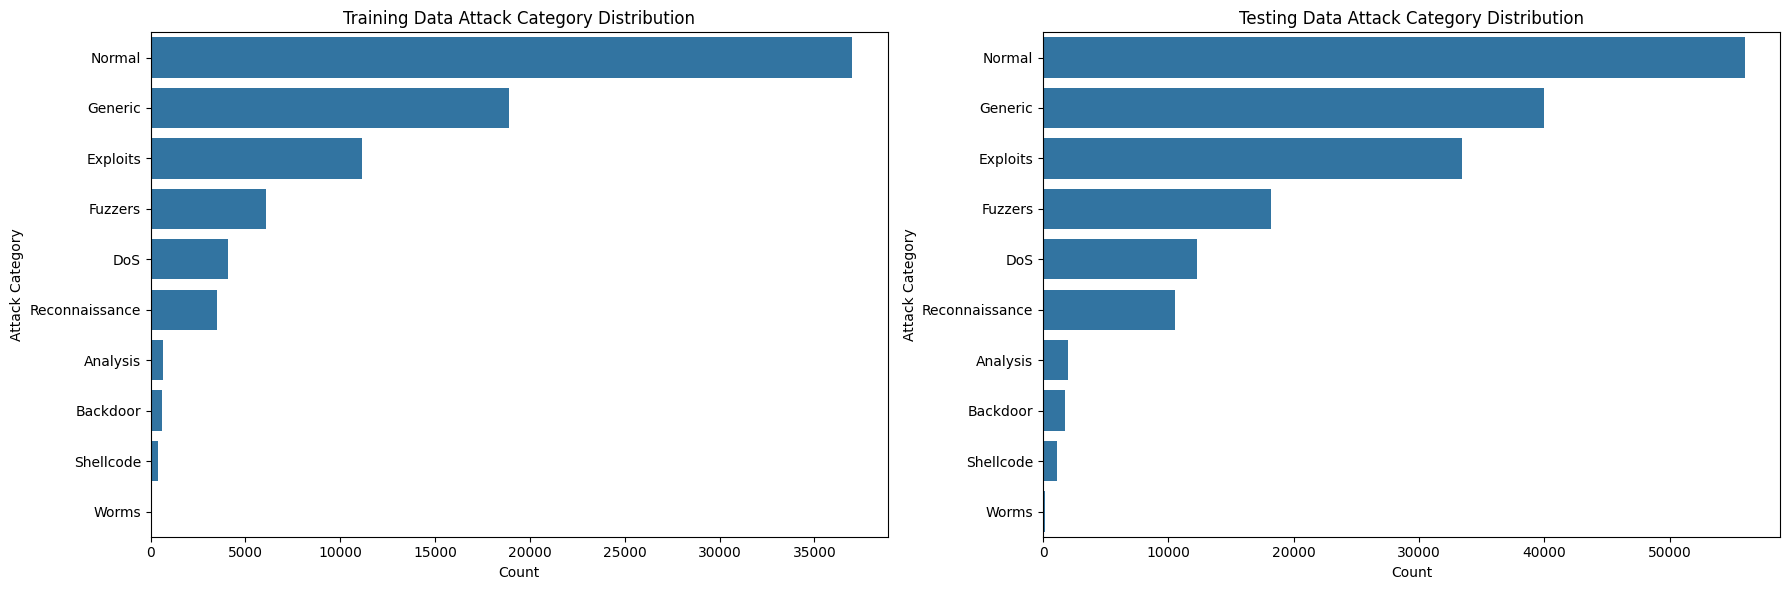

In [ ]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Count plot for attack categories in training data
sns.countplot(y="attack_cat", data=train, order=train["attack_cat"].value_counts().index, ax=axes[0])
axes[0].set_title("Training Data Attack Category Distribution")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Attack Category")

# Count plot for attack categories in testing data
sns.countplot(y="attack_cat", data=test, order=test["attack_cat"].value_counts().index, ax=axes[1])
axes[1].set_title("Testing Data Attack Category Distribution")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Attack Category")

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

# **Data Preprocessing**

In [ ]:
train.isnull().sum()

,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


In [ ]:
# Select only categorical columns
categorical_cols = train.select_dtypes(include=['object'])

# Print the first few rows of categorical columns
print(categorical_cols.head())

# Get the list of categorical column names
list_cat = categorical_cols.columns.tolist()
print(list_cat)

# Print the values of categorical columns
print(categorical_cols.values)

  proto service state attack_cat
0   udp       -   INT     Normal
1   udp       -   INT     Normal
2   udp       -   INT     Normal
3   udp       -   INT     Normal
4   udp       -   INT     Normal
['proto', 'service', 'state', 'attack_cat']
[['udp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']
 ...
 ['arp' '-' 'INT' 'Normal']
 ['arp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']]


In [ ]:
# Select only numerical columns
numerical_cols = train.select_dtypes(exclude=['object'])

# Print the first few rows of numerical columns
print(numerical_cols.head())

# Get the list of numerical column names
list_num = numerical_cols.columns.tolist()
print(list_num)

# Display summary statistics for numerical columns
numerical_cols.describe()


   id       dur  spkts  dpkts  sbytes  dbytes         rate  sttl  dttl  \
0   1  0.000011      2      0     496       0   90909.0902   254     0   
1   2  0.000008      2      0    1762       0  125000.0003   254     0   
2   3  0.000005      2      0    1068       0  200000.0051   254     0   
3   4  0.000006      2      0     900       0  166666.6608   254     0   
4   5  0.000010      2      0    2126       0  100000.0025   254     0   

         sload  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0  180363632.0  ...                 1                 1               2   
1  881000000.0  ...                 1                 1               2   
2  854400000.0  ...                 1                 1               3   
3  600000000.0  ...                 2                 1               3   
4  850400000.0  ...                 2                 1               3   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0             0           0    

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [ ]:
# Check if positive labels (1) match attack categories
print("Do positive labels match attack categories?")
print((train.label == 1).equals(train.attack_cat != 'Normal'))

print("\nDo attack categories match labelled data?")
print((train.attack_cat != 'Normal').equals(train.label == 1))

# Display attack category counts
print("\nAttack category distribution:")
print(train.attack_cat.value_counts())

# Analyze protocols and services for positive (attack) labels
print("\nProtocols and services in positively labelled (attack) entries:")
attacks = train[train.label == 1]
print("Service distribution:")
print(attacks.service.value_counts())
print("Protocol distribution:")
print(attacks.proto.value_counts())

# Analyze protocols and services for negative (normal) labels
print("\nProtocols and services in negatively labelled (normal) entries:")
normal = train[train.label == 0]
print("Service distribution:")
print(normal.service.value_counts())
print("Protocol distribution:")
print(normal.proto.value_counts())


Do positive labels match attack categories?
True

Do attack categories match labelled data?
True

Attack category distribution:
attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

Protocols and services in positively labelled (attack) entries:
Service distribution:
service
-           19778
dns         18299
http         4274
smtp         1216
ftp           794
ftp-data      447
pop3          423
ssl            30
snmp           29
dhcp           26
radius          7
irc             5
ssh             4
Name: count, dtype: int64
Protocol distribution:
proto
udp         21321
tcp         15247
unas         3515
ospf          638
sctp          324
            ...  
sccopmce       32
iplt           32
pipe           32
sps            32
ib             31
Name: count, 

In [ ]:
# Combine train and test datasets
df = pd.concat([train, test], ignore_index=True)

# Drop unnecessary columns ('id' and 'attack_cat') as they don't contribute to the model
df.drop(columns=['id', 'attack_cat'], inplace=True)

# Apply one-hot encoding to categorical features ('proto', 'state', 'service')
df = pd.get_dummies(df, columns=["proto", "state", "service"])

# Split the data back into training and testing sets
train_data = df.iloc[:175341, :]
test_data = df.iloc[175341:, :]

# Separate labels (target variable) from features
y_train = train_data.pop("label").values
y_test = test_data.pop("label").values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_data, y_train)

# Normalize feature values using Min-Max Scaling
scaler = MinMaxScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(test_data)

# Print dataset shapes for verification
print(f"Train data shape: {X_train_resampled.shape}, Train label shape: {y_train_resampled.shape}")
print(f"Test data shape: {X_test.shape}, Test label shape: {y_test.shape}")


Train data shape: (178058, 196), Train label shape: (178058,)
Test data shape: (82332, 196), Test label shape: (82332,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:21:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9339260554826799
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.94      0.58      3971
           1       1.00      0.93      0.96     78361

    accuracy                           0.93     82332
   macro avg       0.71      0.94      0.77     82332
weighted avg       0.97      0.93      0.95     82332



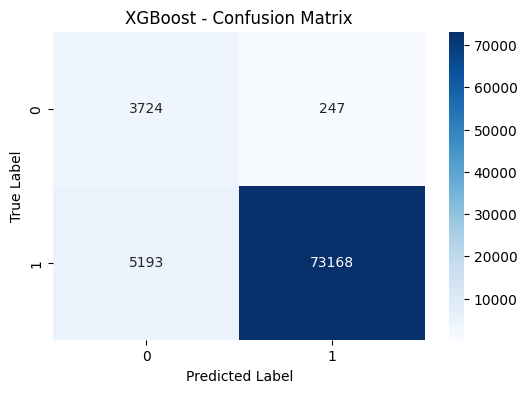

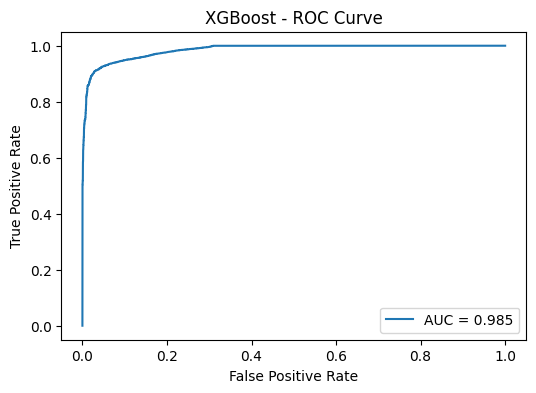

In [ ]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Evaluate Model
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap="Blues")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend()
plt.show()


Accuracy: 0.9365617256959626
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.93      0.59      3971
           1       1.00      0.94      0.97     78361

    accuracy                           0.94     82332
   macro avg       0.71      0.93      0.78     82332
weighted avg       0.97      0.94      0.95     82332



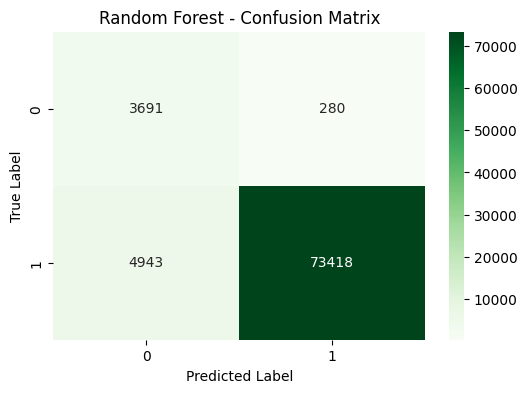

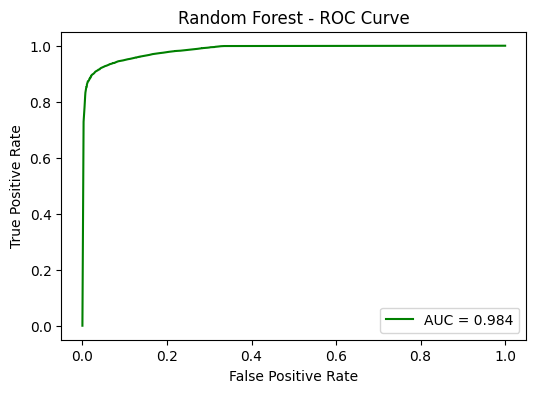

In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}", color="green")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.show()

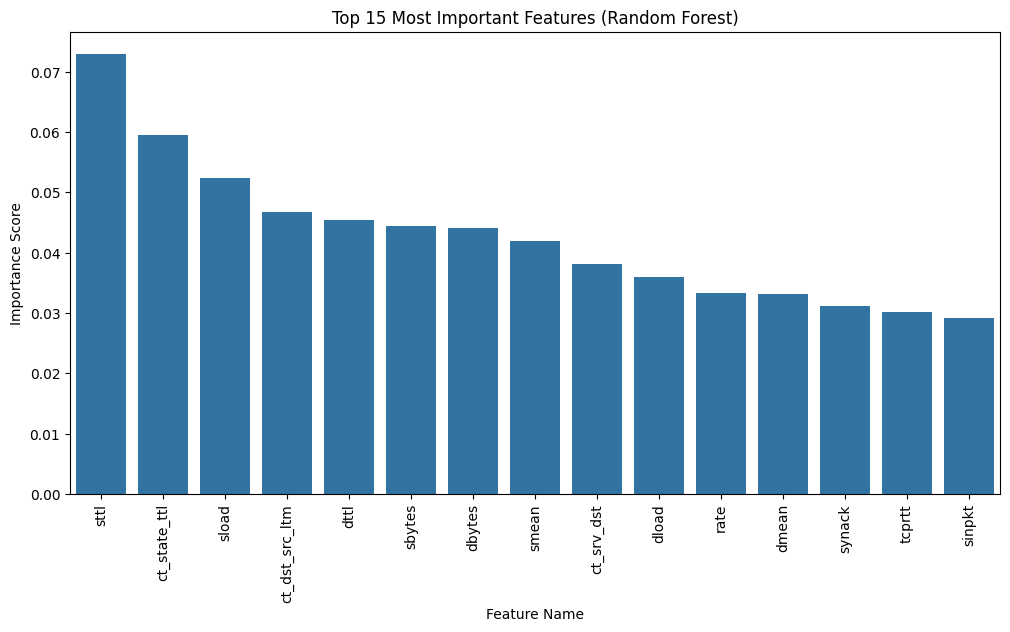

In [ ]:
import numpy as np

# Extract feature importance
importances = rf_model.feature_importances_
feature_names = train_data.columns

# Sort feature importance
indices = np.argsort(importances)[::-1]

# Plot Top Features
plt.figure(figsize=(12,6))
sns.barplot(x=[feature_names[i] for i in indices[:15]], y=importances[indices[:15]])
plt.xticks(rotation=90)
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8685 - loss: 0.2519 - val_accuracy: 0.9142 - val_loss: 0.1365
Epoch 2/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9133 - loss: 0.1753 - val_accuracy: 0.9261 - val_loss: 0.1171
Epoch 3/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9174 - loss: 0.1680 - val_accuracy: 0.9294 - val_loss: 0.1149
Epoch 4/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9186 - loss: 0.1656 - val_accuracy: 0.9013 - val_loss: 0.1432
Epoch 5/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9208 - loss: 0.1630 - val_accuracy: 0.8999 - val_loss: 0.1258
Epoch 6/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9227 - loss: 0.1613 - val_accuracy: 0.9263 - val_loss: 0.1217
Epoch 7/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9226 - loss: 0.1611 - val_accuracy: 0.9302 - val_loss: 0.1148
Epoch 8/10
5565/5565 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9241 - loss: 0

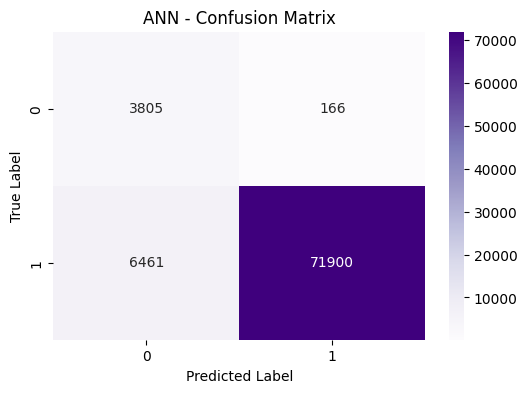

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


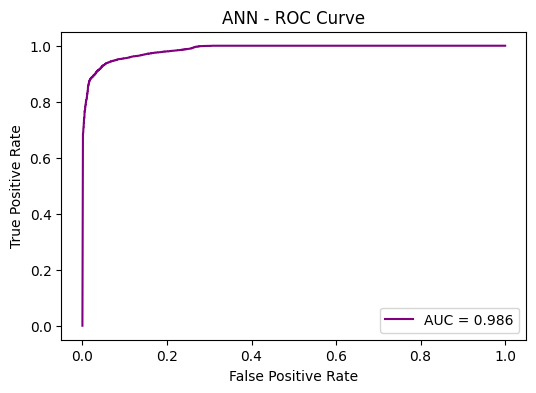

In [ ]:
# Build ANN Model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train ANN Model
ann_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype("int32").flatten()

# Evaluate Model
print(f"Accuracy: {accuracy_score(y_test, y_pred_ann)}")
print("Classification Report:\n", classification_report(y_test, y_pred_ann))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_ann), annot=True, fmt='d', cmap="Purples")
plt.title("ANN - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ann_model.predict(X_test))
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.3f}", color="purple")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN - ROC Curve")
plt.legend()
plt.show()

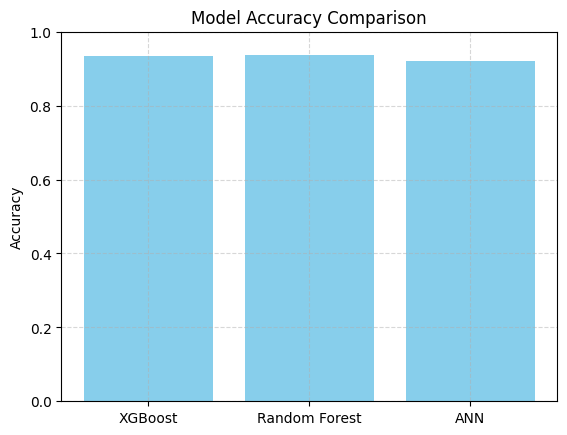

In [3]:
import matplotlib.pyplot as plt
models = ['XGBoost', 'Random Forest', 'ANN']
accuracy = [0.9339, 0.9366, 0.9195]

plt.figure()
plt.bar(models, accuracy, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


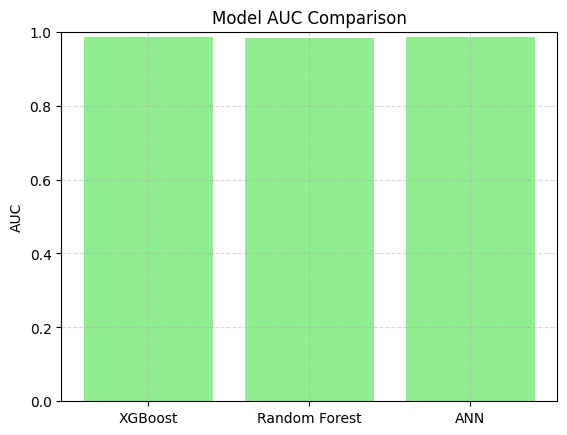

In [4]:
auc = [0.985, 0.984, 0.986]

plt.figure()
plt.bar(models, auc, color='lightgreen')
plt.title('Model AUC Comparison')
plt.ylabel('AUC')
plt.ylim(0.0, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


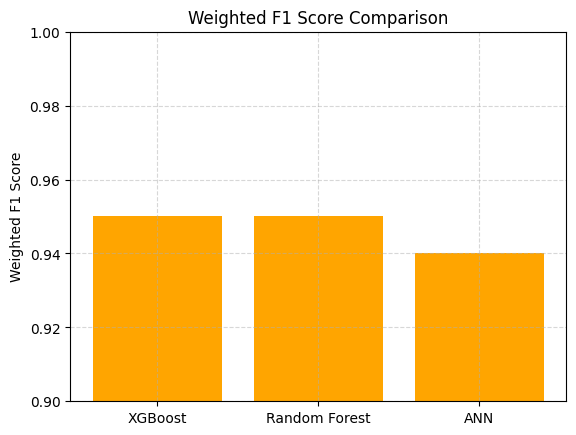

In [5]:
weighted_f1 = [0.95, 0.95, 0.94]

plt.figure()
plt.bar(models, weighted_f1, color='orange')
plt.title('Weighted F1 Score Comparison')
plt.ylabel('Weighted F1 Score')
plt.ylim(0.90, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


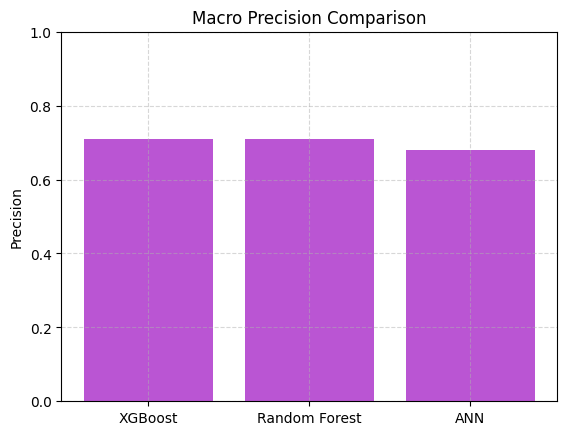

In [6]:
precision = [0.71, 0.71, 0.68]  # Using macro average precision from your classification reports

plt.figure()
plt.bar(models, precision, color='mediumorchid')
plt.title('Macro Precision Comparison')
plt.ylabel('Precision')
plt.ylim(0.0, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


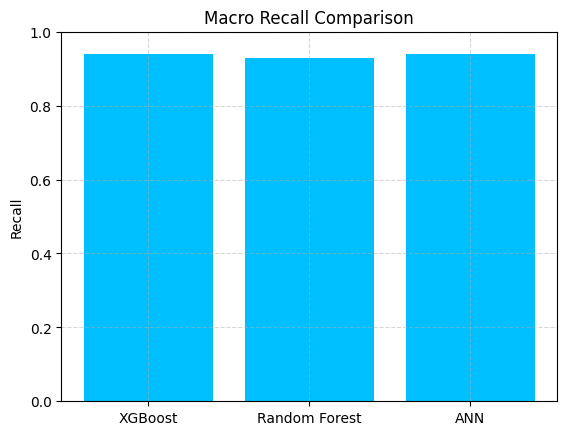

In [8]:
recall = [0.94, 0.93, 0.94]  # Using macro average recall from your classification reports

plt.figure()
plt.bar(models, recall, color='deepskyblue')
plt.title('Macro Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0.0, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
